In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import glob
from radioReduction import *
from astropy.stats import LombScargle
from scipy import optimize
from scipy.interpolate import make_interp_spline, BSpline



In [2]:
dt = sorted(glob.glob('1314/dataTables/*-LLRR.dat'))


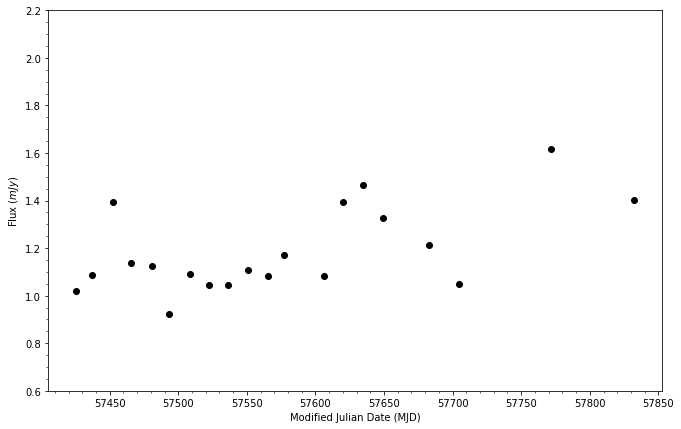

NameError: name 'fracPol' is not defined

<Figure size 792x504 with 0 Axes>

In [7]:
mjd,re,ure = [],[],[]
for i in dt:
    x = pd.read_table(i)
    m,f,e = meanData(x)
    mjd.append(m)
    re.append(f)
    ure.append(e)
    
longTerm = pd.DataFrame(data={'mjd':mjd,'re':re,'ure':ure})
longTerm = longTerm.sort_values('mjd')

plt.figure(figsize=(11,7))
plt.errorbar(longTerm['mjd'],longTerm['re'],yerr=longTerm['ure'],linestyle='none',color='k',fmt='o')
plt.xlabel('Modified Julian Date (MJD)')
plt.ylabel('Flux ($mJy$)')
plt.ylim(0.6,2.2)
plt.minorticks_on()
plt.show()

plt.figure(figsize=(11,7))
plt.errorbar(longTerm['mjd'],fracPol,yerr=fracErr,linestyle='None',color='black',fmt='o')
plt.xlabel('Modified Julian Date (MJD)')
plt.ylabel('Faction of Circ. Pol. (%)')
plt.ylim(-50,50)
plt.minorticks_on()
plt.show()


fig,ax = plt.subplots(figsize=(11,7),nrows=2,ncols=1,sharex=True,gridspec_kw={'hspace':0.01,'height_ratios':[4,1]})
ax[0].errorbar(longTerm['mjd'],longTerm['re'],yerr=longTerm['ure'],linestyle='none',color='k',fmt='o')
ax[0].set_ylabel('Flux ($mJy$)')
ax[0].set_ylim(0.6,2.2)
ax[0].minorticks_on()

ax[1].errorbar(longTerm['mjd'],fracPol,yerr=fracErr,linestyle='-',color='black')
ax[1].set_ylabel('Frac. Circ. Pol. (%)')
ax[1].set_ylim(-25,25)
ax[1].axhline(y=0,linestyle='dashed',color='k')
ax[1].minorticks_on()

plt.xlabel('Modified Julian Date (MJD)')
plt.show()

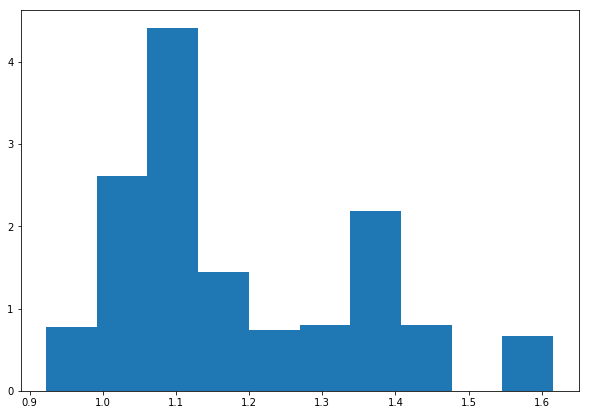

In [4]:
plt.figure(figsize=(10,7))
plt.hist(longTerm['re'],weights=longTerm['ure'],density=True)
plt.show()

In [6]:
'''
Fitting a mean model
'''
chi2 = np.sum(np.square((longTerm['re']-longTerm['re'].mean())/longTerm['ure']))/(longTerm.shape[0]-1)
print(chi2)

677.7123402029196


In [8]:
'''
Calculating fraction of circular polarization
'''
fracPol = (stV/stI)*100
fracErr = np.abs(fracPol)*np.sqrt((stErr/stV)**2+(stErr/stI)**2)
print(fracPol)
print(fracErr)
print(np.mean(fracPol),1/np.sqrt(np.sum(1/fracErr**2)))

NameError: name 'stV' is not defined

In [62]:
stI

0     1.021544
1     1.085722
2     1.393863
3     1.137192
4     1.125314
5     0.922378
6     1.086893
7     1.044387
8     1.043440
9     1.108496
10    1.083422
11    1.170183
12    1.081222
13    1.391187
14    1.464946
15    1.324204
16    1.215506
17    1.051044
18    1.611060
19    1.404118
Name: re, dtype: float64

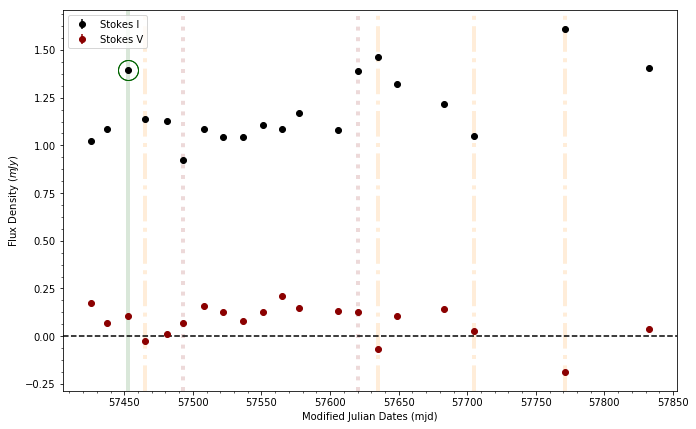

In [72]:
plt.figure(figsize=(11,7))
plt.errorbar(longTerm['mjd'],stI,yerr=stErr,fmt='o',color='black',linestyle='None',label='Stokes I')
plt.errorbar(time,stV,yerr=stErr,fmt='o',color='darkred',linestyle='None',label='Stokes V')

# Pointing out epochs with flares/step-behavior
circle_rad = 10
plt.plot(57452.489273,stI[2],marker='o',ms=circle_rad*2, mec='darkgreen', mfc='none')
plt.plot(57452.489273,stI[2],marker='o',ms=circle_rad*2, mec='darkgreen', mfc='none')

plt.axvline(x=57452.489273,color='darkgreen',linewidth=4,alpha=0.15)
plt.axvline(x=57620.018996,color='darkred',linestyle=':',linewidth=4,alpha=0.15)
plt.axvline(x=57493.139864,color='darkred',linestyle=':',linewidth=4,alpha=0.15)
plt.axvline(x=57465.226390,color='darkorange',linestyle='-.',linewidth=4,alpha=0.15)
plt.axvline(x=57634.996105,color='darkorange',linestyle='-.',linewidth=4,alpha=0.15)
plt.axvline(x=57704.824840,color='darkorange',linestyle='-.',linewidth=4,alpha=0.15)
plt.axvline(x=57771.525539,color='darkorange',linestyle='-.',linewidth=4,alpha=0.15)

# Making it look pretty
plt.axhline(y=0,color='k',linestyle='dashed')
plt.minorticks_on()
plt.ylabel('Flux Density ($mJy$)')
plt.xlabel('Modified Julian Dates (mjd)')
plt.legend(loc=2)

#plt.savefig('plots/1314LongTerm.png')
plt.show()

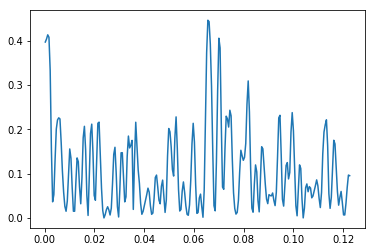

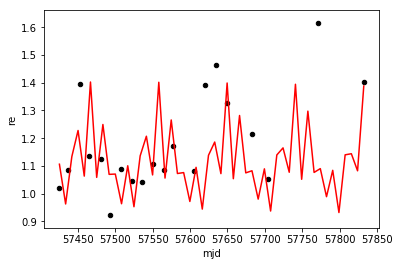

15.235518391369958


In [34]:
freq, power = LombScargle(longTerm['mjd'],longTerm['re'],longTerm['ure']).autopower()
plt.plot(freq,power)
plt.show()
best_freq = freq[np.argmax(power)]
x_fit = np.linspace(np.min(longTerm['mjd']),np.max(longTerm['mjd']),num=50)
y_fit = LombScargle(longTerm['mjd'],longTerm['re'],longTerm['ure'],nterms=3).model(x_fit,best_freq)

longTerm.plot.scatter('mjd','re',yerr='ure',color='black')
plt.plot(x_fit,y_fit,color='red')
plt.show()

print(1/best_freq)

## Looking at SED and Stokes V

In [31]:
# SED
low = glob.glob('1314/dataTables/*-5GHz.dat')

re = []
ure = []
mjd = []

for i in low:
    x = pd.read_table(i)
    m,r,e = meanData(x)
    mjd.append(m)
    re.append(r)
    ure.append(e)
    
low = pd.DataFrame(data={'mjd':mjd,'re':re,'ure':ure})
low = low.sort_values('mjd')
low = low.reset_index(drop=True)

high = glob.glob('1314/dataTables/*-7GHz.dat')

re = []
ure = []
mjd = []

for i in high:
    x = pd.read_table(i)
    m,r,e = meanData(x)
    mjd.append(m)
    re.append(r)
    ure.append(e)
    
high = pd.DataFrame(data={'mjd':mjd,'re':re,'ure':ure})
high = high.sort_values('mjd')
high = high.reset_index(drop=True)

ratio = high['re']/low['re']
ratioErr = np.abs(ratio)*np.sqrt((high['ure']/high['re'])**2+(low['ure']/low['re'])**2)

# Stokes V
ll = glob.glob('1314/dataTables/*-LL.dat')
rr = glob.glob('1314/dataTables/*-RR.dat')

re = []
ure = []
mjd = []

for i in ll:
    x = pd.read_table(i)
    m,r,e = meanData(x)
    mjd.append(m)
    re.append(r)
    ure.append(e)
    
ll = pd.DataFrame(data={'mjd':mjd,'re':re,'ure':ure})
ll = ll.sort_values('mjd')
ll = ll.reset_index(drop=True)

re = []
ure = []
mjd = []

for i in rr:
    x = pd.read_table(i)
    m,r,e = meanData(x)
    mjd.append(m)
    re.append(r)
    ure.append(e)
    
rr = pd.DataFrame(data={'mjd':mjd,'re':re,'ure':ure})
rr = rr.sort_values('mjd')
rr = rr.reset_index(drop=True)

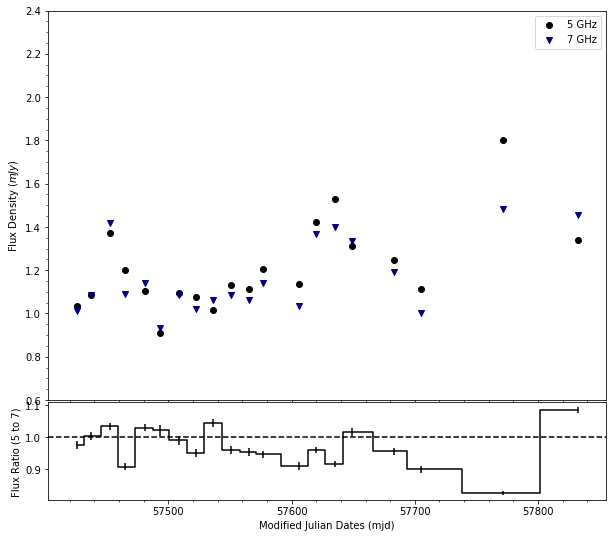

In [10]:
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(10,9),gridspec_kw = {'hspace':.01,'height_ratios':[4,1]},sharex=True)
ax[0].scatter(low['mjd'],low['re'],color='k',marker='o',label='5 GHz')
ax[0].errorbar(low['mjd'],low['re'],yerr=low['ure'],color='k',linestyle='None',label='_nolegend_')
ax[0].scatter(high['mjd'],high['re'],color='navy',marker='v',label='7 GHz')
ax[0].errorbar(high['mjd'],high['re'],yerr=high['ure'],color='navy',linestyle='None',label='_nolegend_')
ax[0].legend(loc='best')
ax[0].set_ylabel('Flux Density ($mJy$)')
ax[0].set_ylim(0.6,2.4)
ax[0].minorticks_on()

ax[1].plot(low['mjd'],ratio,color='black',drawstyle='steps-mid')
ax[1].axhline(y=1,color='k',linestyle='dashed')
ax[1].errorbar(low['mjd'],ratio,color='black',yerr=ratioErr,linestyle='none',label='_nolegend_')
ax[1].set_ylabel('Flux Ratio (5 to 7)')
plt.xlabel('Modified Julian Dates (mjd)')
#plt.savefig('plots/SED_Ratio_1314.png')
plt.show()

In [11]:
# Calculating spectral index alpha
alpha = np.log10(ratio)/np.log10(7/5)

# Calculating Error on alpha
errLogR = ratioErr/ratio
alphaErr = np.abs(1/np.log10(7/5))*errLogR

# Calculating the stokes V
stI = (rr['re']+ll['re'])*.5
stV = (rr['re']-ll['re'])*.5
frac = stV/stI
stErr = np.sqrt(rr['ure']**2+ll['ure']**2)*.5
time = rr['mjd']

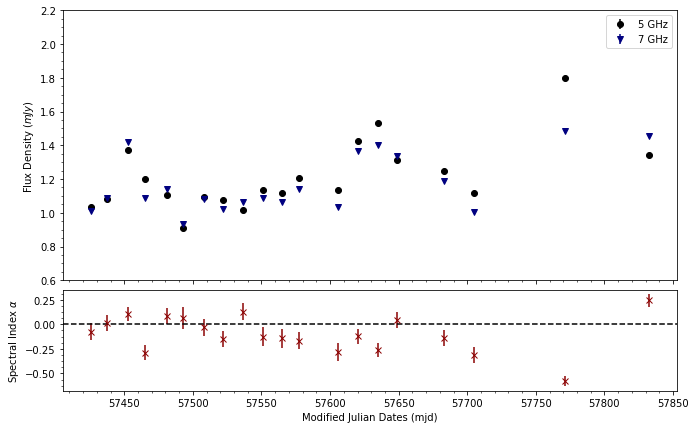

In [30]:
# PLotting SED compared to alpha values
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(11,7),gridspec_kw = {'hspace':.05,'height_ratios':[4,1.5]},sharex=True)
ax[0].errorbar(low['mjd'],low['re'],yerr=low['ure'],color='k',fmt='o',linestyle='None',label='5 GHz')
ax[0].errorbar(high['mjd'],high['re'],yerr=high['ure'],color='navy',fmt='v',linestyle='None',label='7 GHz')
ax[0].legend(loc='best')
ax[0].set_ylabel('Flux Density ($mJy$)')
ax[0].set_ylim(0.6,2.2)
# Pointing out epochs with flares/step-behavior
# ax[0].axvline(x=57452.489273,color='darkgreen',linewidth=4,alpha=0.15)
# ax[0].axvline(x=57620.018996,color='darkred',linestyle=':',linewidth=4,alpha=0.15)
# ax[0].axvline(x=57493.139864,color='darkred',linestyle=':',linewidth=4,alpha=0.15)
# ax[0].axvline(x=57465.226390,color='darkorange',linestyle='-.',linewidth=4,alpha=0.15)
# ax[0].axvline(x=57634.996105,color='darkorange',linestyle='-.',linewidth=4,alpha=0.15)
# ax[0].axvline(x=57704.824840,color='darkorange',linestyle='-.',linewidth=4,alpha=0.15)
# ax[0].axvline(x=57771.525539,color='darkorange',linestyle='-.',linewidth=4,alpha=0.15)
ax[0].minorticks_on()

ax[1].errorbar(low['mjd'],alpha,color='darkred',yerr=alphaErr,fmt='x',linestyle='None',label='_nolegend_')
ax[1].axhline(y=0,color='k',linestyle='dashed')
ax[1].set_ylabel('Spectral Index $\\alpha$')
ax[1].minorticks_on()

plt.xlabel('Modified Julian Dates (mjd)')
plt.savefig('plots/1314_SED_Alpha.png')
plt.show()

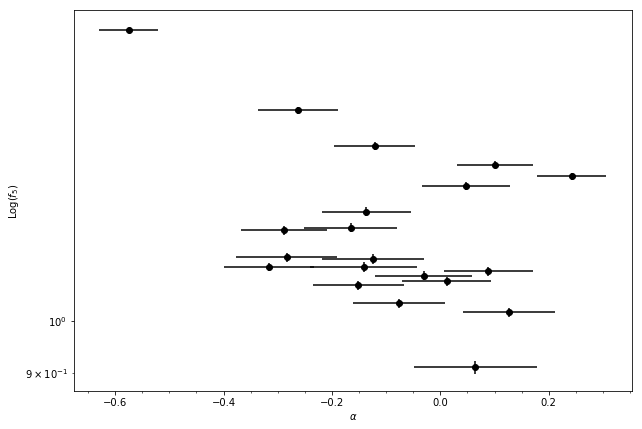

In [35]:
plt.figure(figsize=(10,7))
plt.errorbar(alpha,low['re'],yerr=low['ure'],xerr=alphaErr,linestyle='none',marker='o',color='k')
plt.yscale('log')
plt.minorticks_on()
plt.ylabel('Log($f_5$)')
plt.xlabel('$\\alpha$')
plt.show()

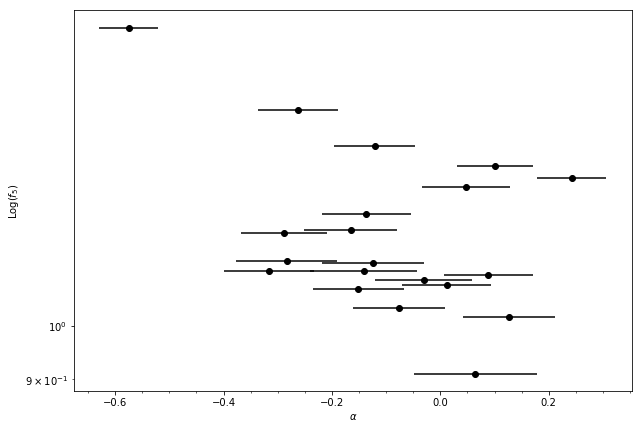

In [40]:
plt.figure(figsize=(10,7))
plt.semilogy(alpha,low['re'],linestyle='none',marker='o',color='k')
plt.errorbar(alpha,low['re'],xerr=alphaErr,linestyle='None',color='k')
#plt.yscale('log')
plt.minorticks_on()
plt.ylabel('Log($f_5$)')
plt.xlabel('$\\alpha$')
plt.show()

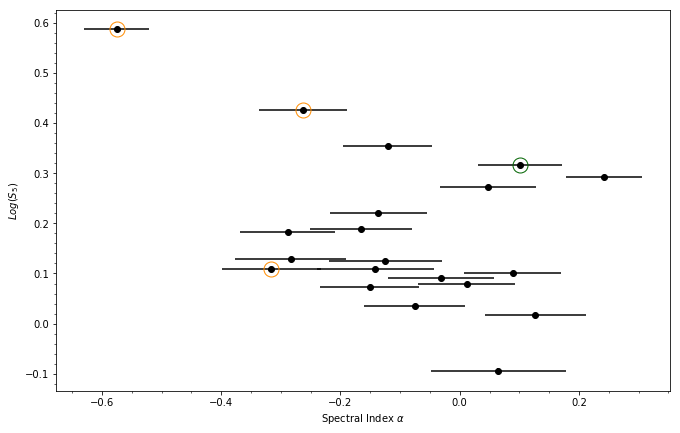

In [41]:
log5 = np.log(low['re'])
log5Err = 0.434*(low['ure']/low['re'])
plt.figure(figsize=(11,7))
plt.errorbar(alpha,log5,yerr=log5Err,xerr=alphaErr,linestyle='None',color='k',marker='o')

ep = [14,17,18]
for i in ep:
    plt.errorbar(alpha[i],log5[i],linestyle='none',color='darkorange',marker='o',markerfacecolor='None',ms=15)
plt.errorbar(alpha[2],log5[2],linestyle='none',color='darkgreen',marker='o',markerfacecolor='None',ms=15)
plt.xlabel('Spectral Index $\\alpha$')
plt.ylabel('$Log(S_5)$')
plt.minorticks_on()
plt.savefig('plots/1314_alphaLog5.png')
plt.show()

In [13]:
print(low['re'].iloc[18]/high['re'].iloc[18])

1.2135780586877558


In [14]:
stV.mean()

0.07811676387939497

In [22]:
stV.std()
std = stV.std()
mean = stV.mean()

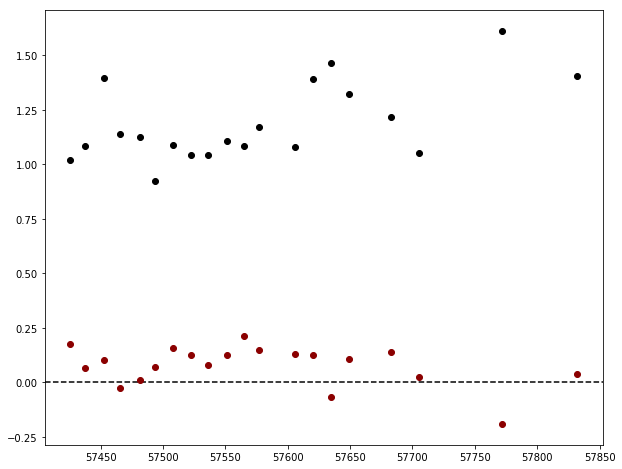

In [29]:
plt.figure(figsize=(10,8))
plt.errorbar(time,stI,yerr=stErr,color='k',fmt='o',label='Stokes I')
plt.errorbar(time,stV,yerr=stErr,color='darkred',fmt='o',label='Stokes V')

plt.axhline(y=0,color='k',linestyle='dashed')
#plt.fill_between(time,mean,mean-std,color='darkred',alpha=0.1)
#plt.fill_between(time,mean,mean+std,color='darkred',alpha=0.1)
#plt.fill_between(time,mean,mean-2*std,color='darkorange',alpha=0.1)

plt.show()